In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as colors

In [4]:
#open dgurba shapefile which incudes the LAU boundaries
URBA = gpd.read_file("covid_emo_top_loc/DGURBA/DGURBA-2020-01M-SH.shp")
#use only the Italian LAU
URBA = URBA.loc[URBA['CNTR_CODE']=='IT']
#reproject it in an Italian projection
URBA= URBA.to_crs(epsg=6875)

In [6]:
#open pop grid shapefile which represents population in a grid of 1km*1km squares
pop_grid = gpd.read_file("JRC_GRID_2018/JRC_POPULATION_2018.shp")

In [9]:
#using only Italian squares of the grid
pop_grid = pop_grid.loc[pop_grid.CNTR_ID=='IT']

In [14]:
#reproject it in an Italian projection
pop_grid = pop_grid.to_crs(epsg=6875)

(6528889.810734834, 7604737.409320234, 3859150.893099356, 5273947.02225592)

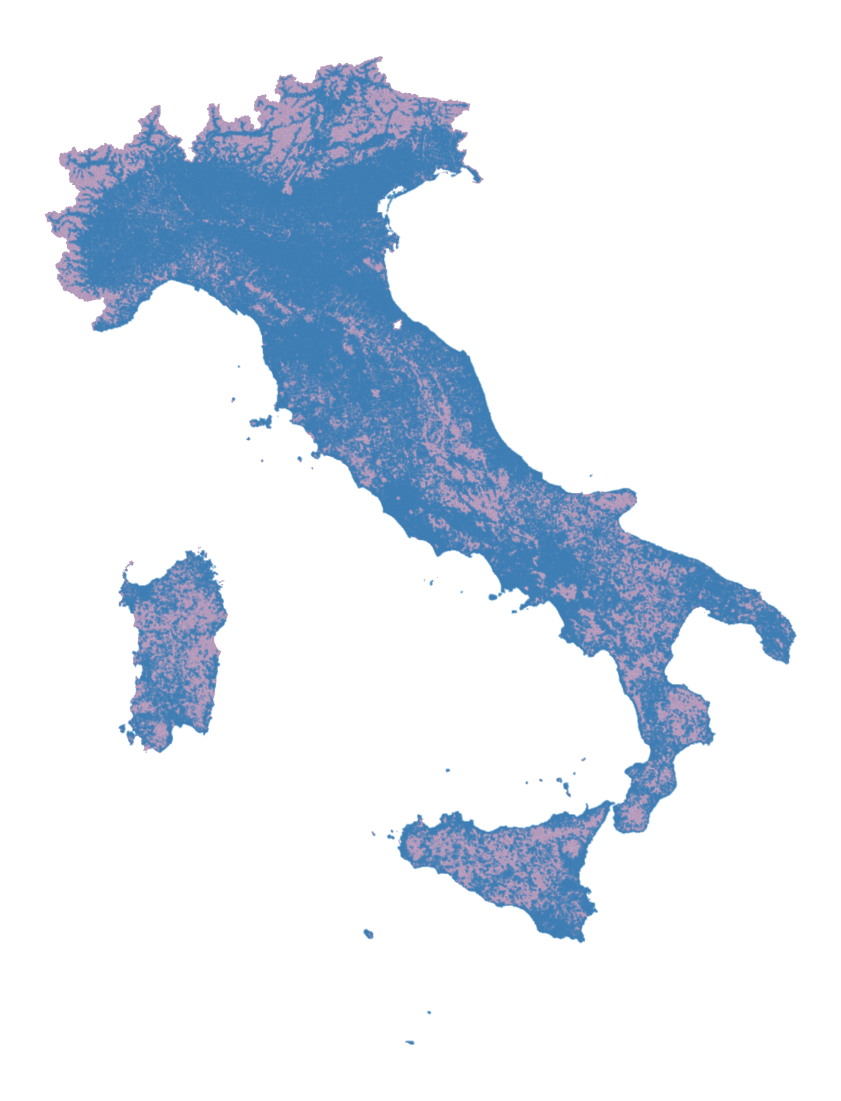

In [17]:
fig, ax = plt.subplots(figsize=(20,20))
URBA.plot(ax=ax, color='#440154', alpha=0.4)
pop_grid.boundary.plot(ax=ax, alpha=0.2)
plt.axis('off')

<AxesSubplot:>

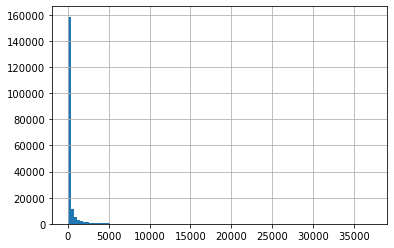

In [24]:
#histogram of the population grid data. Classic annoying distribution :)))
pop_grid.TOT_P_2018.hist(bins=100)

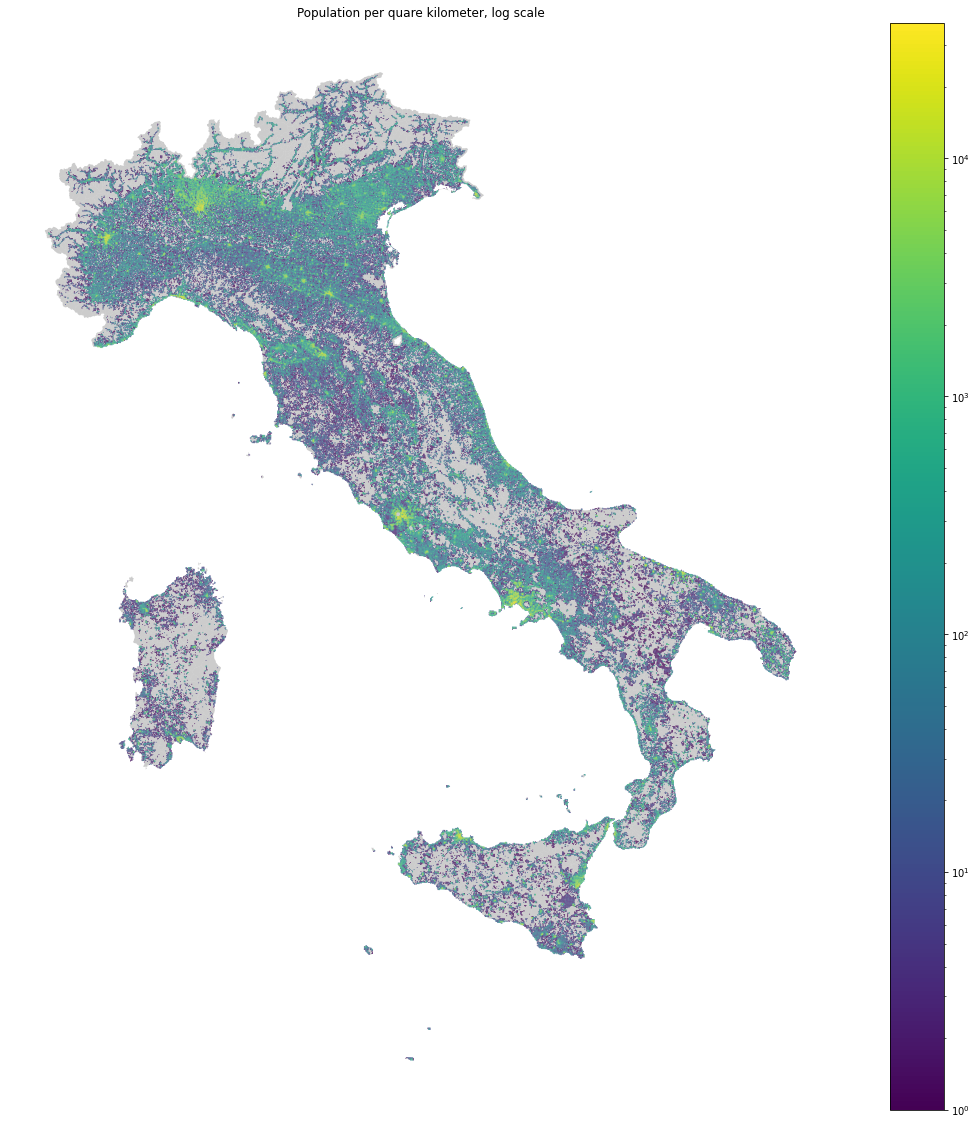

In [30]:
fig, ax = plt.subplots(figsize=(20,20))
URBA.plot(ax=ax, color='black', alpha=0.2)
pop_grid.iloc[:].plot(ax=ax, column="TOT_P_2018", legend=True, norm=colors.LogNorm(vmin=1, vmax=int(pop_grid.TOT_P_2018.max())))
plt.axis('off')
plt.title('Population per quare kilometer, log scale')
plt.savefig('covid_emo_top_loc/maps/pop_grid_logscale.png')

In [34]:
#we create a dataframe of the overlay areas between the population grid and the LAU areas
urba_grid_overlay = gpd.overlay(URBA, pop_grid)

In [36]:
#we look at the areas of the overlay zones
urba_grid_overlay_area = urba_grid_overlay.area
urba_grid_overlay['overlay_area'] = urba_grid_overlay_area

In [44]:
#the grid squares area is not exactly 1squ km so we save it again in a new column
pop_grid['area'] = pop_grid.area

In [48]:
#we merge the dataframes to have all areas in a single dataframe
urba_grid_overlay_areas= urba_grid_overlay.merge(pop_grid[['OBJECTID', 'TOT_P_2018', 'area']], left_on='OBJECTID_2', right_on='OBJECTID', how='left')

In [116]:
#now we compute the weighted population per LAU, by 
#looking at the fraction fo the grid square that overlaps with the LAU
urba_grid_overlay_areas['fraction'] = urba_grid_overlay_areas['overlay_area']/urba_grid_overlay_areas['area']
#multpiplying this fraction by the population of the grid square
urba_grid_overlay_areas['fraction_pop'] = urba_grid_overlay_areas['fraction']*urba_grid_overlay_areas['TOT_P_2018_y']
#and finally summing all the populations computed within a single LAU
weighted_pop_lau = urba_grid_overlay_areas[['OBJECTID_1', 'fraction_pop']].groupby('OBJECTID_1').sum()

In [62]:
#let's check the overall population
#in the grid, looking at Italy's population
pop_grid.TOT_P_2018.values.sum()

60097866

In [118]:
weighted_pop_lau['fraction_pop'].sum()

59323503.68380455

In [ ]:
#we can see that the populations are quite different. Let's try to figure out why

In [83]:
#let's look for grid squares that are not part of a LAU 
tmp = urba_grid_overlay.merge(pop_grid, left_on="OBJECTID_2", right_on="OBJECTID", how='right')
tmp_b = tmp.loc[tmp['OBJECTID_2'].isnull()]
tmp_gdf = gpd.GeoDataFrame(tmp_b, geometry='geometry_y')

<AxesSubplot:>

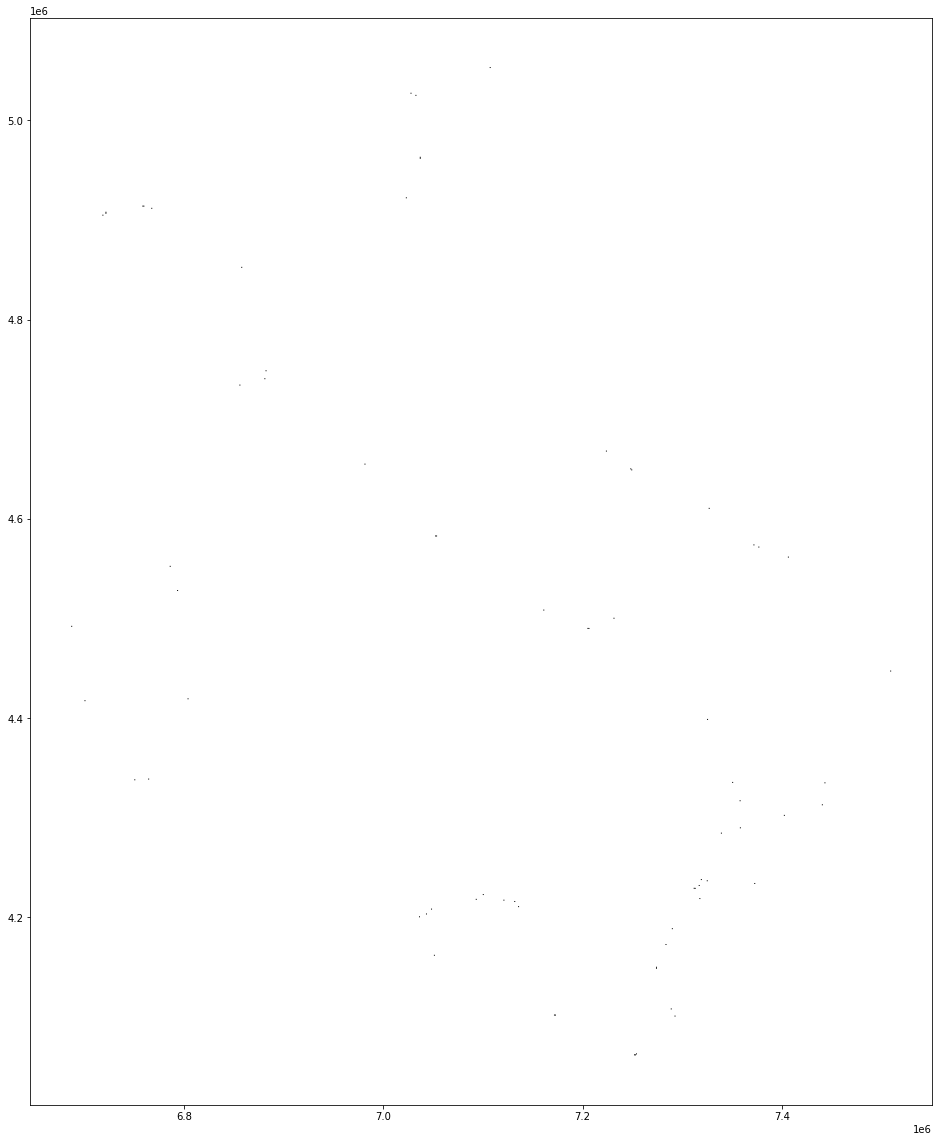

In [97]:
fig, ax = plt.subplots(figsize=(20,20))
tmp_gdf.iloc[:].plot(ax=ax, color='black')

In [256]:
tmp_gdf.TOT_P_2018_y.values.sum()

1400

These squares are not matched with any LAU, and could therefore explain the mismatch of the values. However, looking at the sum of the populations in these grid squares, we only arrive at 1400 people, which is far from explaining the mismatch observed. In all likelihood, there must also be squares that partly overlap with LAU regions, and partly overlap with no region, and those must make up the majority of the missing population

Let's try to confirm this, and then find a way to fix this.

In [127]:
#looking, in the overlay dataframe, at the sum of the overlay surfaces by squares against the square total area
#the two should be equal. If not, it means some are
sum_areas_grid = urba_grid_overlay_areas[["OBJECTID", 'overlay_area', 'area', 'TOT_P_2018_y', 'fraction_pop']].groupby('OBJECTID').agg({'overlay_area':['sum', 'idxmax'], 'area':'first', 'TOT_P_2018_y': 'first', 'fraction_pop': 'sum'})

In [141]:
sum_areas_grid

overlay_area                   area TOT_P_2018_y fraction_pop  \
                    sum  idxmax          first        first          sum   
OBJECTID                                                                   
1802      401390.389872  210946  997073.092358           32    12.882197   
1803      446403.708847  210947  997075.727833          143    64.022951   
1804      770134.299321  210948  997078.411449         1028   794.017853   
1805      824175.402237  210949  997081.143209          129   106.629864   
1806      130734.282450  210950  997083.923113            6     0.786700   
...                 ...     ...            ...          ...          ...   
853406    997003.589430  149739  997003.589430          158   158.000000   
853407    997003.975277  149740  997003.975277          142   142.000000   
854511    997003.986004  149741  997003.986004           72    72.000000   
854512    997004.422014  149742  997004.422014           73    73.000000   
855641    997004.920221  149743  997004.920221            4     4.000000   

           overlay_area fraction_pop  
                   diff         diff  
OBJECTID                              
1802      595682.702485    19.117803  
1803      550672.018986    78.977049  
1804      226944.112129   233.982147  
1805      172905.740972    22.370136  
1806      866349.640662     5.213300  
...                 ...          ...  
853406         0.000000     0.000000  
853407         0.000000     0.000000  
854511         0.000000     0.000000  
854512         0.000000     0.000000  
855641         0.000000     0.000000  

[187373 rows x 7 columns]

In [140]:
sum_areas_grid['fraction_pop', 'diff'] = sum_areas_grid['TOT_P_2018_y', 'first']-sum_areas_grid['fraction_pop', 'sum']

Now we have the sum of sub overlay areas over the matching LAUs, the index of the largest overlay in the previous dataframe, the overall area for the square grid, the population of the square grid, as well as the population already matched with other LAUs, as well as the difference in population

<AxesSubplot:>

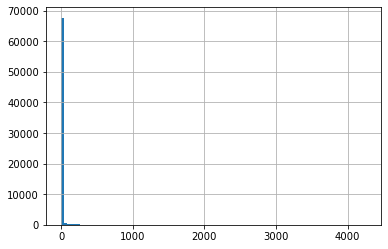

In [142]:
sum_areas_grid.loc[sum_areas_grid['fraction_pop', 'diff']!=0]['fraction_pop', 'diff'].hist(bins=100)

As we can tell, it seems the majority of the areas match, or almost do, while some miss the LAU almost entirely. Plus some grid squares fully don't match the LAU, as observed above. We now have to fix two possible cases:
- when the grid square partly matches a LAU
- when the grid square is outside all LAUs


For the former case, we will recompute the grid area, not to be the area of the square, but to be the sum of the overlay areas in that square. This will allow us to recompute the fraction of the population to account for the fact that the square might not fully overlap with land area;

For the latter case, we will look for the closest LAU, and assign the entire grid square population to that LAU. For computational reasons, we will ignore grid squares with a population of 0.


In [260]:
overall_grid_areas = urba_grid_overlay_areas[["OBJECTID", 'overlay_area', 'area', 'TOT_P_2018_y', 'fraction_pop']].groupby('OBJECTID').agg({'overlay_area':'sum'}).rename(columns={'overlay_area':'total_square_area'})
urba_grid_overlay_areas = urba_grid_overlay_areas.merge(overall_grid_areas, left_on='OBJECTID', right_index=True, how='left')
urba_grid_overlay_areas['fraction'] = urba_grid_overlay_areas['overlay_area'] / urba_grid_overlay_areas['total_square_area']
urba_grid_overlay_areas['fraction_pop'] = urba_grid_overlay_areas['TOT_P_2018_y'] * urba_grid_overlay_areas['fraction']
weighted_pop_lau_updated = urba_grid_overlay_areas[['OBJECTID_1', 'fraction_pop']].groupby('OBJECTID_1').sum()

In [276]:
weighted_pop_lau_updated = weighted_pop_lau_updated.rename(columns={'fraction_pop':'population'})

In [187]:
pop_grid.TOT_P_2018.values.sum()

60097866

In [277]:
#adding the values of the grid squares not overlapping with any LAU, we match up almost exactly to the Italian population
weighted_pop_lau_updated.population.values.sum() + tmp_gdf.TOT_P_2018_y.values.sum()

60097866.0

For now, let's use the data as it is, as the difference is not significant with or without the remaining grid squares

In [278]:
italy = gpd.read_file("covid_emo_top_loc/ITA/ITA_adm3.shp")

In [279]:
regions = italy[['NAME_1', "geometry"]].dissolve(by='NAME_1')

In [280]:
URBA_pop = URBA.merge(weighted_pop_lau_updated, left_on='OBJECTID', right_index=True, how='left')
URBA_pop = URBA_pop.fillna(0)

In [281]:
regions_LAU_urba = gpd.sjoin(regions.to_crs(epsg=6875), URBA_pop, op='contains', how='left')

In [282]:
regions_LAU_urba = regions_LAU_urba.reset_index()

In [283]:
wm = lambda x: np.average(x, weights=regions_LAU_urba.loc[x.index, "population"])
weighted_dgurba = regions_LAU_urba.groupby("NAME_1").agg({'geometry': 'first', 'DGURBA':wm, 'population':'sum'})

In [285]:
weighted_dgurba = gpd.GeoDataFrame(weighted_dgurba, geometry='geometry')

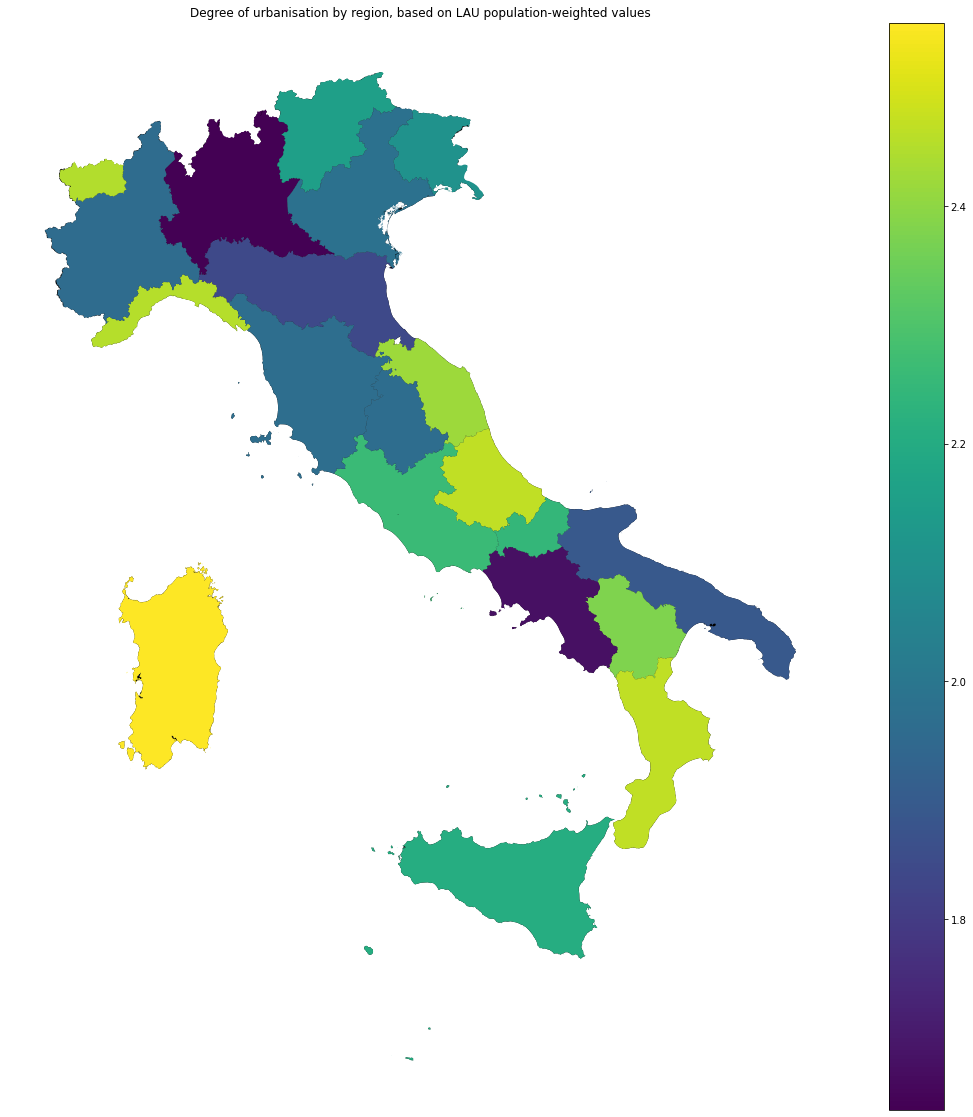

In [286]:
#plotting the URBA score per region, based on the population weighted LAU average
fig, ax = plt.subplots(figsize=(20,20))
URBA.plot(ax=ax, color='black', alpha=1)
weighted_dgurba.plot(column='DGURBA', legend=True, ax=ax)
plt.axis('off')
plt.title('Degree of urbanisation by region, based on LAU population-weighted values')
plt.savefig('covid_emo_top_loc/maps/dgurba_region_popweighted.png')

In [287]:
weighted_dgurba.to_file("data/computed/pop_weighted_DGURBA_by_region.shp")

In [290]:
regions_LAU_urba.to_file('data/computed/DGURBA_pop_region.shp')

C:\Users\margo\AppData\Local\Temp/ipykernel_20324/1076089585.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  regions_LAU_urba.to_file('data/computed/DGURBA_pop_region.shp')


In [326]:
tmp = URBA.merge(weighted_pop_lau_updated, left_on='OBJECTID', right_index=True)

In [343]:
tmp['ceiling_pop_9'] = tmp.apply(lambda x: min(x['population'], np.quantile(tmp.population, 0.9)), axis=1)
tmp['ceiling_pop_95'] = tmp.apply(lambda x: min(x['population'], np.quantile(tmp.population, 0.95)), axis=1)
tmp['ceiling_pop_99'] = tmp.apply(lambda x: min(x['population'], np.quantile(tmp.population, 0.99)), axis=1)

Text(0.5, 1.0, 'Population per LAU')

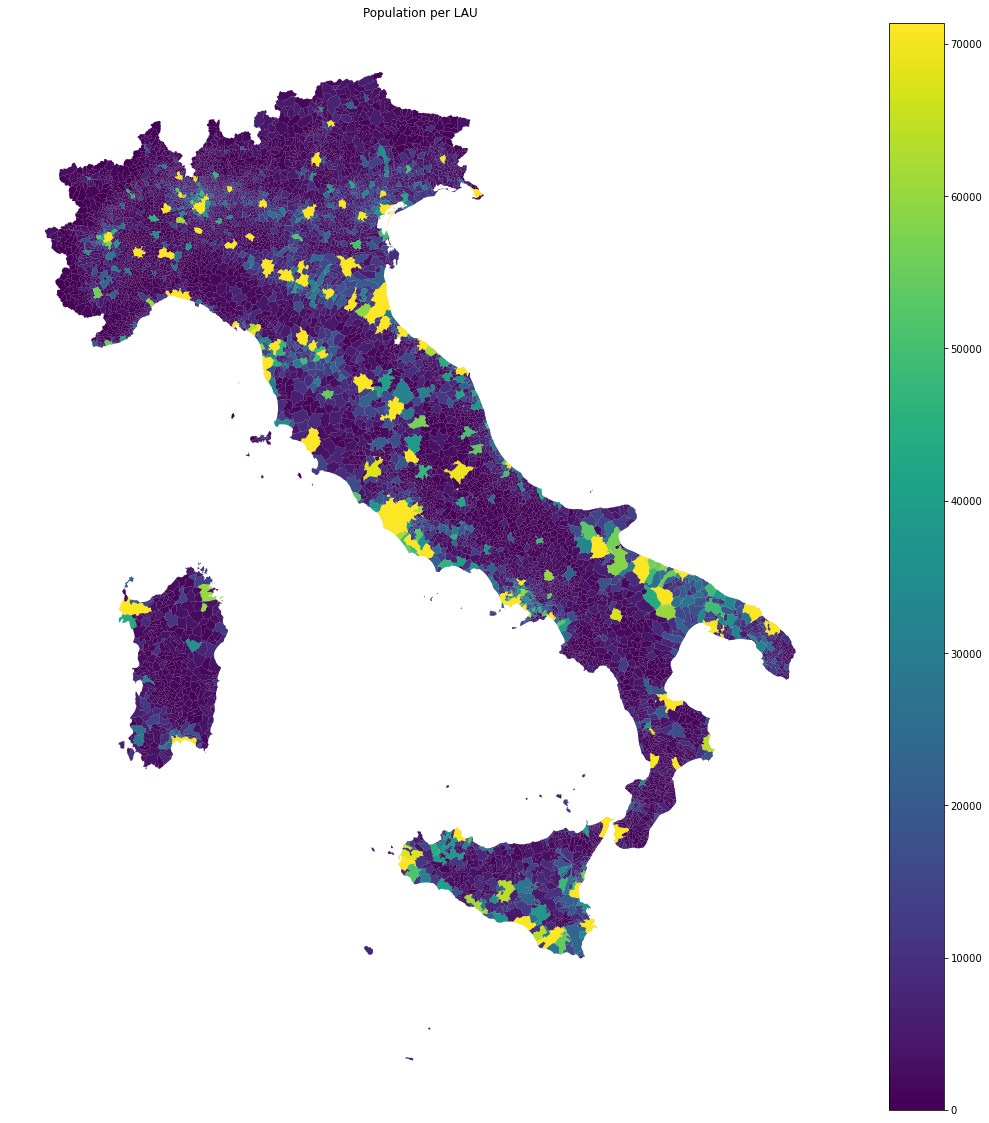

In [344]:
fig, ax = plt.subplots(figsize=(20,20))
URBA.plot(ax=ax, color='black', alpha=0.2)
tmp.iloc[:].plot(ax=ax, column="ceiling_pop_99", legend=True)
plt.axis('off')
plt.title('Population per LAU')

Text(0.5, 1.0, 'Population per LAU, log scale')

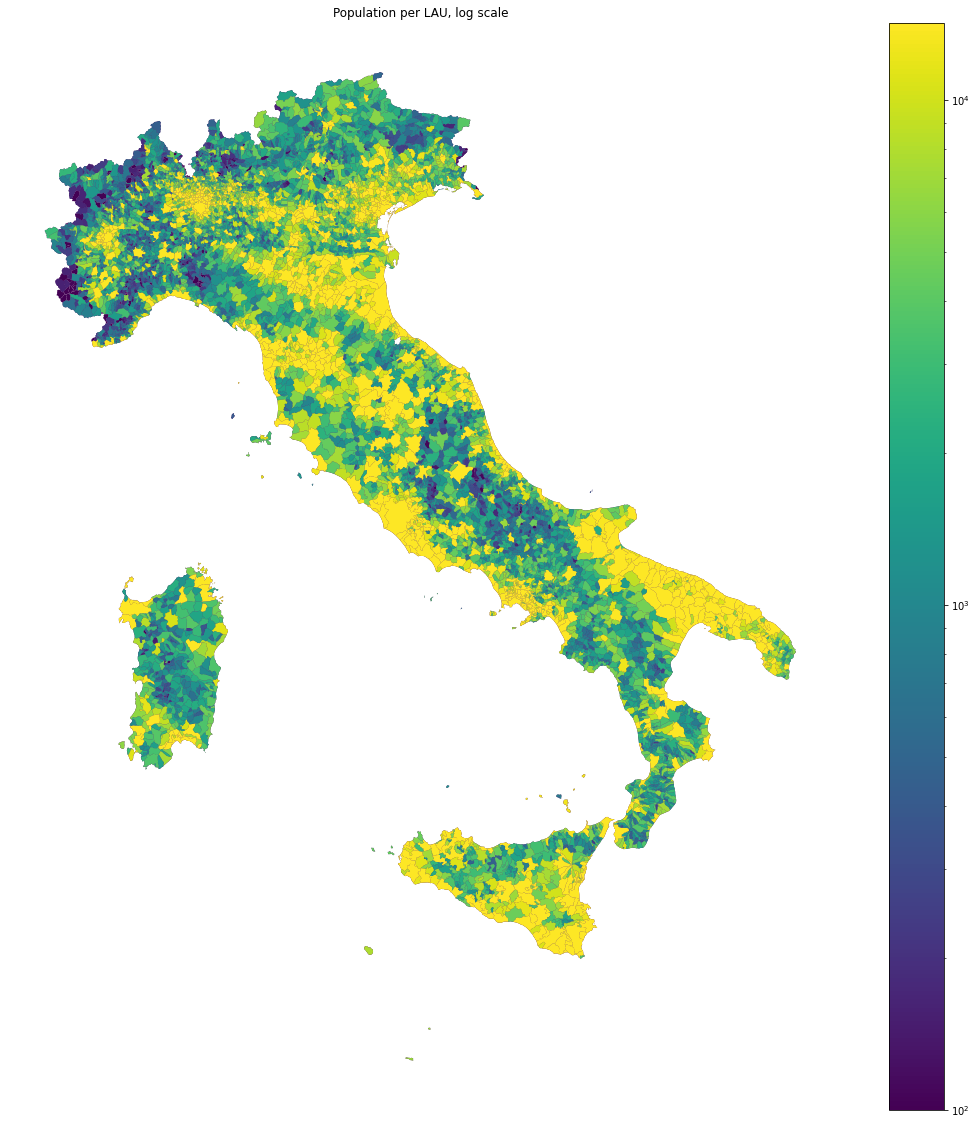

In [351]:
fig, ax = plt.subplots(figsize=(20,20))
URBA.plot(ax=ax, color='#440154', alpha=1)
tmp.loc[tmp.population>100].plot(ax=ax, column="population", legend=True, norm=colors.LogNorm(vmin=100, vmax=int(tmp.ceiling_pop_9.max())))
plt.axis('off')
plt.title('Population per LAU, log scale')
# plt.savefig('covid_emo_top_loc/maps/pop_grid_logscale.png')

## OLD CODE

In [69]:
#now we build the population per LAU dictionnary
weighted_pop={}
#for each LAU 
for lau in set(urba_grid_overlay_areas['OBJECTID_1'].values):
    #we look at the overlay areas of all the grid squares in the current LAU
    #we save that dataframe as tmp
    tmp = urba_grid_overlay_areas.loc[urba_grid_overlay_areas['OBJECTID_1']==lau]
    #we build temporary values to help us in the computation
    #first: the fraction of the grid square included in the LAU
    tmp['frac'] = tmp['overlay_area']/tmp['area']
    #we multiply this fraction with the population of the grid square, 
    #as we assume the population to be homogeneous within a single grid square
    tmp['weighted_pop']=tmp['frac']*tmp['TOT_P_2018_y']
    #we do the sum of the included grid square populations in that LAU,
    #which gives us an approximation of that LAU population
    population = tmp['weighted_pop'].sum()
    #we save that values in the dictionnary, with a new entry
    #the key of which is the LAU ID
    weighted_pop[lau]=population

C:\Users\margo\anaconda3\envs\GISenv\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Previous method for computing population mismatch

In [145]:
#we look at the LAUs that matched the highest value of the overlay
#these are the LAus to which we'll assign the remaining fraction fo the population in the grid square
idx = sum_areas_grid['overlay_area', 'idxmax'].values

In [152]:
LAUS = urba_grid_overlay_areas.loc[idx]['OBJECTID_1'].values

In [150]:
sum_areas_grid['fraction_pop','LAU'] = LAUS

In [169]:
sum_areas_grid

overlay_area                   area TOT_P_2018_y fraction_pop  \
                    sum  idxmax          first        first          sum   
OBJECTID                                                                   
1802      401390.389872  210946  997073.092358           32    12.882197   
1803      446403.708847  210947  997075.727833          143    64.022951   
1804      770134.299321  210948  997078.411449         1028   794.017853   
1805      824175.402237  210949  997081.143209          129   106.629864   
1806      130734.282450  210950  997083.923113            6     0.786700   
...                 ...     ...            ...          ...          ...   
853406    997003.589430  149739  997003.589430          158   158.000000   
853407    997003.975277  149740  997003.975277          142   142.000000   
854511    997003.986004  149741  997003.986004           72    72.000000   
854512    997004.422014  149742  997004.422014           73    73.000000   
855641    997004.920221  149743  997004.920221            4     4.000000   

           overlay_area fraction_pop          
                   diff         diff     LAU  
OBJECTID                                      
1802      595682.702485    19.117803  181303  
1803      550672.018986    78.977049  181303  
1804      226944.112129   233.982147  181303  
1805      172905.740972    22.370136  181303  
1806      866349.640662     5.213300  181303  
...                 ...          ...     ...  
853406         0.000000     0.000000  176648  
853407         0.000000     0.000000  176648  
854511         0.000000     0.000000  176648  
854512         0.000000     0.000000  176648  
855641         0.000000     0.000000  176648  

[187373 rows x 8 columns]

In [163]:
relevant_sum_areas_grid = sum_areas_grid.loc[sum_areas_grid['overlay_area', 'diff']>0]

In [173]:
#grouping this by LAU, we now have a dataframe of the population to add by LAU
pop_to_add = relevant_sum_areas_grid[[['fraction_pop', 'LAU'],['fraction_pop', 'diff']]].groupby(('fraction_pop', 'LAU')).sum()

In [174]:
pop_to_add

,fraction_pop
,diff
"(fraction_pop, LAU)",
173632,6.059331e-11
173633,8.779200e-11
173634,9.201528e-13
173635,2.611245e-11
173636,3.124114e-10
...,...
182569,8.407862e+00
182570,2.191580e-13


In [190]:
#we join that with the previously defined population by LAU, and sum both to obtain the final population
final_weighted_pop_lau = pd.DataFrame(weighted_pop_lau.merge(pop_to_add, right_index=True, left_index=True, how='left').fillna(0).sum(axis=1)).rename(columns={0:'population'})

In [186]:
#looking at the overall population now, it is much closer to the overall italian population
final_weighted_pop_lau.population.values.sum()

60096466.00000115